<a href="https://colab.research.google.com/github/KurovDenis/ASI-Arch/blob/main/77418_%22takt_v01_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЯЧЕЙКА 0: КОНФИГУРАЦИОННЫЕ НАСТРОЙКИ (ПОД ПРИМЕР ИЗ ТЗ #77418)

МОДЕЛИ ОБОРУДОВАНИЯ (из ТЗ):
  Модель1: Цех='Цех1', ФРВ=21ч, Макс.исп=7
  ДругаяМодель: Цех='Цех1', ФРВ=20ч, Макс.исп=4

НАСТРОЙКИ РАСПИСАНИЯ ЦЕХА 1:
  Цех: Цех1
  Первая смена (начало): 7
  Первая смена (окончание): 19
  Вторая смена (начало): 19
  Вторая смена (окончание): 3
  Нерабочий период (начало): 3
  Нерабочий период (окончание): 7

ИЗДЕЛИЕ: хоппер_ТЗ
КОЛИЧЕСТВО К ВЫПУСКУ: 5 шт
ДАТА ВЫПУСКА: 15.09.2025

СТРУКТУРА ИЗДЕЛИЯ (ВЛОЖЕННАЯ):
  хоппер_ТЗ → котел_ТЗ (2 шт на 1 ед. родителя)
  котел_ТЗ → гайка_ТЗ (10 шт на 1 ед. родителя)

Данные о выработке (хроника из ТЗ) загружены.

ЯЧЕЙКА 1: МОДЕЛИ ДАННЫХ

ТЕХПРОЦЕСС ДЛЯ: котел_ТЗ
          Операция  Тшт(мин)
[Котел] Операция 1       120
[Котел] Операция 2       120

ТЕХПРОЦЕСС ДЛЯ: хоппер_ТЗ
            Операция  Тшт(мин)
[Хоппер] Операция 11       180
[Хоппер] Операция 12       300

ТЕХПРОЦЕСС ДЛЯ: гайка_ТЗ
          Операция  Тшт(мин)
[Гайка] Операция 8        60
[Гай

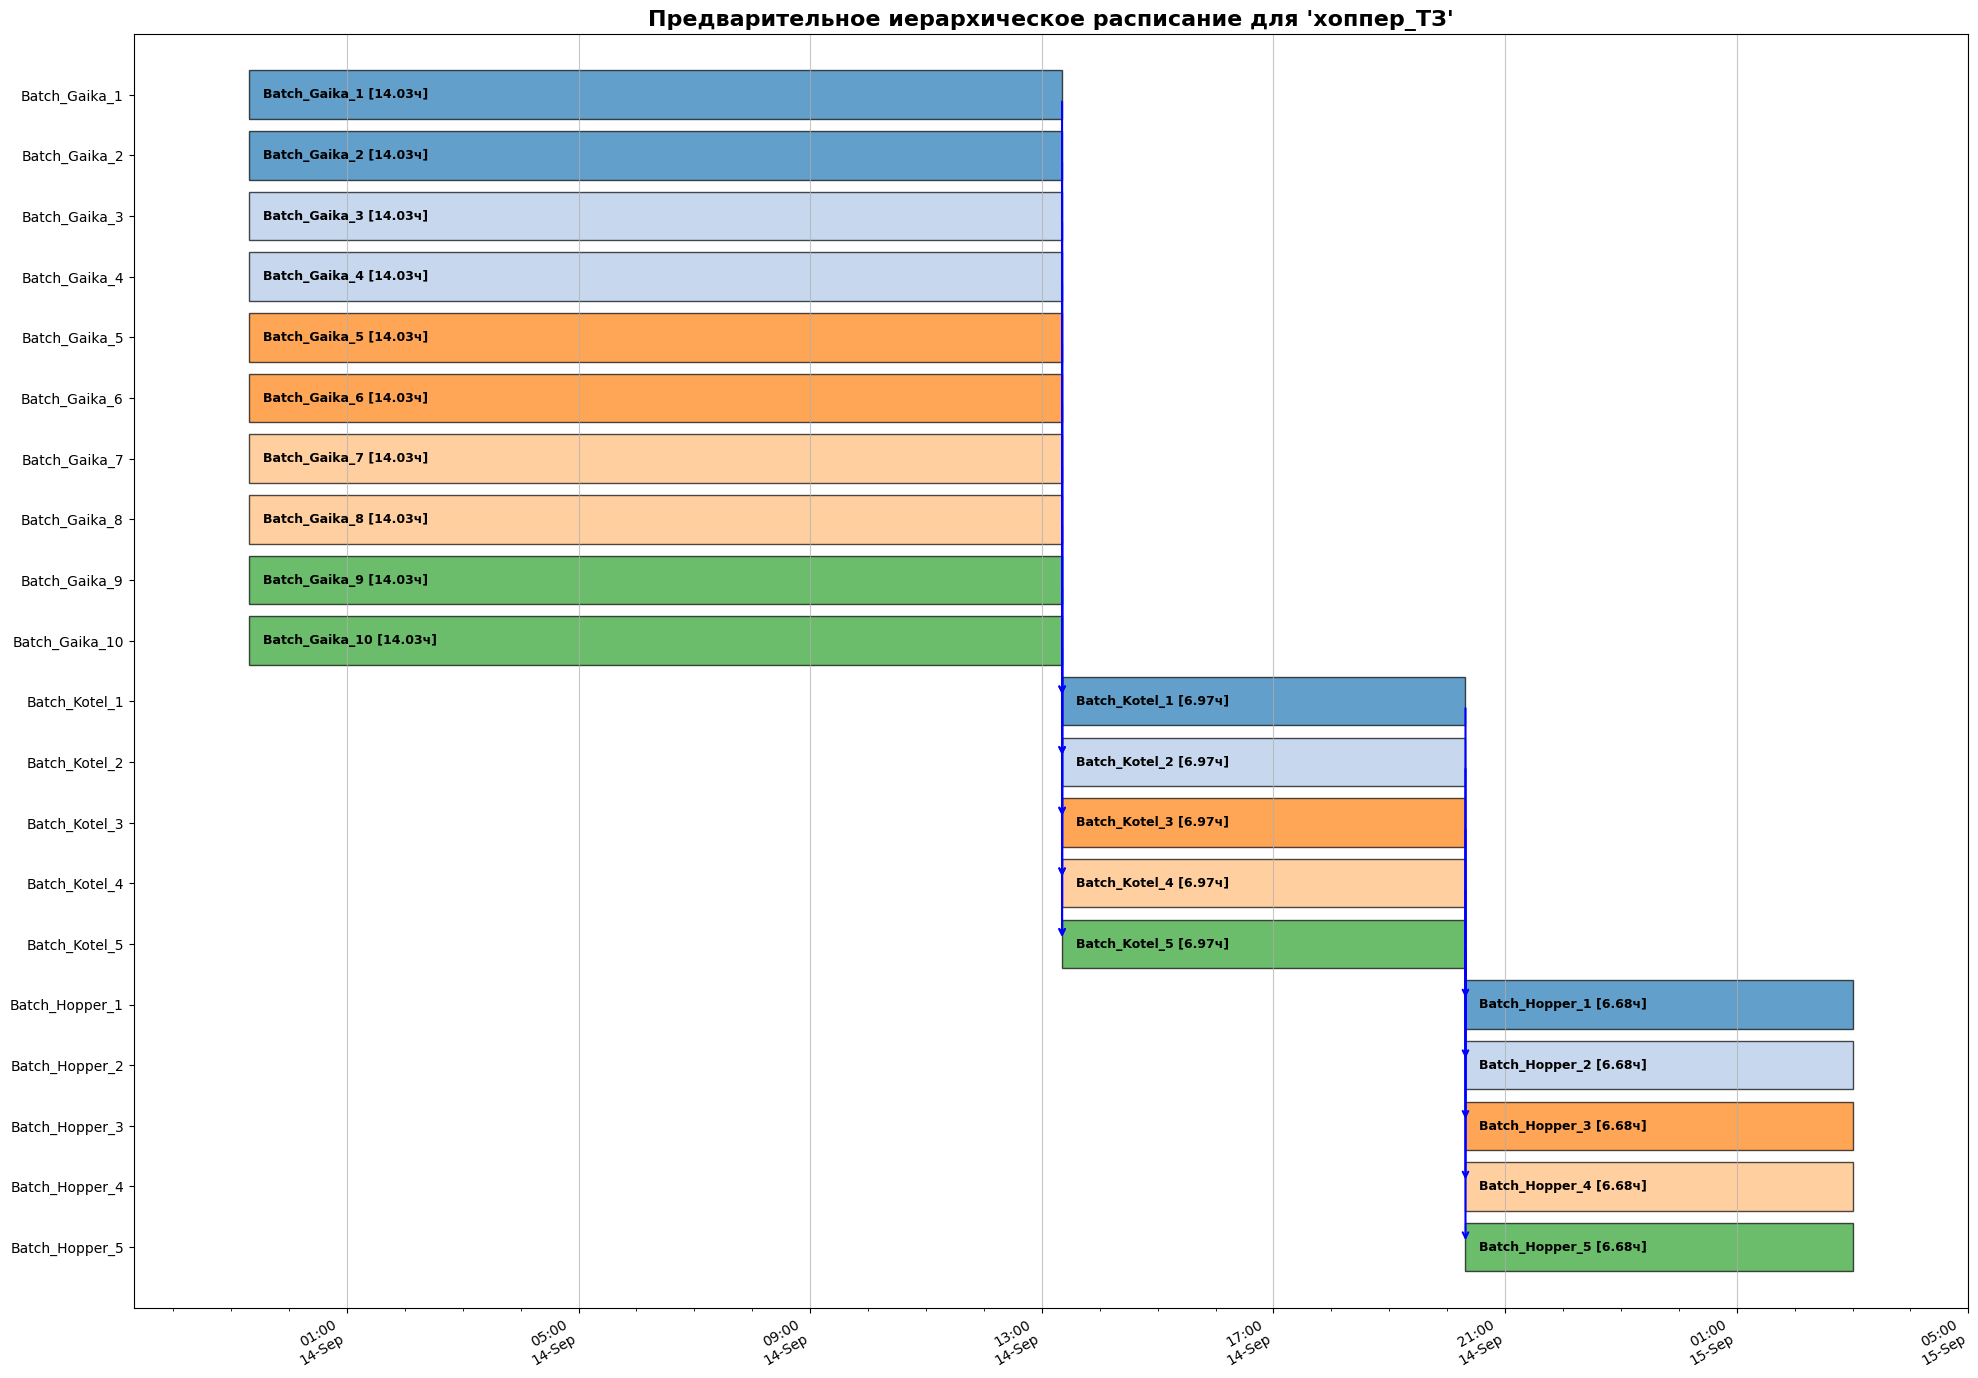

In [1]:
# ==============================================================================
# ЯЧЕЙКА 0: КОНФИГУРАЦИОННЫЕ НАСТРОЙКИ (ПОД ПРИМЕР ИЗ ТЗ #77418)
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
from collections import defaultdict
import math

print("="*80)
print("ЯЧЕЙКА 0: КОНФИГУРАЦИОННЫЕ НАСТРОЙКИ (ПОД ПРИМЕР ИЗ ТЗ #77418)")
print("="*80)

# === КОНСТАНТЫ ДЛЯ КЛЮЧЕЙ СЛОВАРЕЙ ===
WORKSHOP_NAME_KEY = 'Цех'
PRODUCT_NAME_KEY = 'Изделие'
PRODUCT_QUANTITY_KEY = 'Количество к выпуску'
PRODUCT_DATE_KEY = 'Дата выпуска'
BATCH_ID_KEY = 'Items'
BATCH_QUANTITY_KEY = 'Quantity' # НЕ ИСПОЛЬЗУЕТСЯ в новой логике, размер определяется Макс. размером
BATCH_MAX_SIZE_KEY = 'MaxBatchSize'
COMPONENT_QUANTITY_KEY = 'quantity'

# === МОДЕЛИ ОБОРУДОВАНИЯ (ИЗ ПРИМЕРА ТЗ) ===
EQUIPMENT_MODELS = {
    'Модель1': {
        WORKSHOP_NAME_KEY: 'Цех1',
        'available_time_per_day': 21,
        'max_executors': 7
    },
    'ДругаяМодель': {
        WORKSHOP_NAME_KEY: 'Цех1',
        'available_time_per_day': 20,
        'max_executors': 4
    }
}
print("\nМОДЕЛИ ОБОРУДОВАНИЯ (из ТЗ):")
for model_name, details in EQUIPMENT_MODELS.items():
    print(f"  {model_name}: Цех='{details[WORKSHOP_NAME_KEY]}', ФРВ={details['available_time_per_day']}ч, Макс.исп={details['max_executors']}")

# === НАСТРОЙКИ ТАКТИРОВАНИЯ (ИЗ ПРИМЕРА ТЗ) ===
# В новой логике предварительного планирования не используется, но оставлено для справки
PRODUCT_TACT_SETTINGS = {
    'котел_ТЗ': True,
    'хоппер_ТЗ': True,
    'гайка_ТЗ': False
}

# === НАСТРОЙКИ ГРАФИКА ЦЕХА ===
WORK_SCHEDULE = {
    WORKSHOP_NAME_KEY: 'Цех1',
    'Первая смена (начало)': 7, 'Первая смена (окончание)': 19,
    'Вторая смена (начало)': 19, 'Вторая смена (окончание)': 3,
    'Нерабочий период (начало)': 3,'Нерабочий период (окончание)': 7,
}
print("\nНАСТРОЙКИ РАСПИСАНИЯ ЦЕХА 1:")
for key, value in WORK_SCHEDULE.items():
    print(f"  {key}: {value}")

# === ОСНОВНОЙ ПРОИЗВОДСТВЕННЫЙ ЗАКАЗ (ИЗ ПРИМЕРА ТЗ) ===
PRODUCT_INFO = {
    PRODUCT_NAME_KEY: 'хоппер_ТЗ',
    PRODUCT_QUANTITY_KEY: 5,
    PRODUCT_DATE_KEY: '15.09.2025'
}
print(f"\nИЗДЕЛИЕ: {PRODUCT_INFO[PRODUCT_NAME_KEY]}")
print(f"КОЛИЧЕСТВО К ВЫПУСКУ: {PRODUCT_INFO[PRODUCT_QUANTITY_KEY]} шт")
print(f"ДАТА ВЫПУСКА: {PRODUCT_INFO[PRODUCT_DATE_KEY]}")

# === СТРУКТУРА ИЗДЕЛИЯ (СОСТАВ) (ИЗ ПРИМЕРА ТЗ) ===
PRODUCT_STRUCTURE = {
    'хоппер_ТЗ': {
        'котел_ТЗ': { COMPONENT_QUANTITY_KEY: 2 },
    },
    'котел_ТЗ': {
        'гайка_ТЗ': { COMPONENT_QUANTITY_KEY: 10 }
    }
}
print(f"\nСТРУКТУРА ИЗДЕЛИЯ (ВЛОЖЕННАЯ):")
for product, components in PRODUCT_STRUCTURE.items():
    for component, details in components.items():
        print(f"  {product} → {component} ({details[COMPONENT_QUANTITY_KEY]} шт на 1 ед. родителя)")

# === ДАННЫЕ О ВЫРАБОТКЕ (ХРОНИКА) (ИЗ ПРИМЕРА ТЗ) ===
CHRONICA_AUGUST = []
CHRONICA_SEPTEMBER = [
    {'Профессия': 'Клепальщик', 'Разряд': 6, 'Цех': 'Цех1', 'Коэффициент': 1.05},
    {'Профессия': 'Сварщик', 'Разряд': 6, 'Цех': 'Цех1', 'Коэффициент': 1.30},
    {'Профессия': 'Слесарь', 'Разряд': 5, 'Цех': 'Цех1', 'Коэффициент': 1.10},
    {'Профессия': 'Слесарь', 'Разряд': 6, 'Цех': 'Цех1', 'Коэффициент': 1.15},
]
print("\nДанные о выработке (хроника из ТЗ) загружены.")


# ==============================================================================
# ЯЧЕЙКА 1: МОДЕЛИ ДАННЫХ (DATA MODELS)
# ==============================================================================
print("\n" + "="*80)
print("ЯЧЕЙКА 1: МОДЕЛИ ДАННЫХ")
print("="*80)

# Классы Executor и Operation остаются без изменений, но у Operation убираются поля, связанные со сжатием
@dataclass
class Executor:
    """Исполнитель на операции"""
    profession: str
    grade: int
    work_time_minutes: int
    num_executors: int = 1

@dataclass
class Operation:
    """Технологическая операция"""
    name: str; product_name: str; time_type: str; piece_time: float; setup_time: float
    service_time: float; executors: List[Executor]; equipment_model: Optional[str] = None
    transport_time_hours: float = 0.0; quantity: int = 1
    date: Optional[datetime] = None; batch_id: Optional[str] = None
    start_time: Optional[datetime] = None; end_time: Optional[datetime] = None

    def get_total_duration_hours(self, k_vyr: float) -> float:
        n_factor = self.quantity if self.time_type == 'НаДеталь' else 1
        correctable_time = ((self.piece_time * n_factor) + self.setup_time) / k_vyr / 60
        non_correctable_time = (self.service_time * n_factor) / 60
        return correctable_time + non_correctable_time

# === БАЗА ДАННЫХ ТЕХПРОЦЕССОВ (ПОД ПРИМЕР ИЗ ТЗ) ===
OPERATIONS_BY_PRODUCT = {
    'котел_ТЗ': [
        Operation(
            product_name='котел_ТЗ', name='[Котел] Операция 1', time_type='НаДеталь', piece_time=120, setup_time=0, service_time=0,
            executors=[Executor(profession='Клепальщик', grade=6, work_time_minutes=120)], equipment_model='Модель1', transport_time_hours=0.01
        ),
        Operation(
            product_name='котел_ТЗ', name='[Котел] Операция 2', time_type='НаДеталь', piece_time=120, setup_time=0, service_time=0,
            executors=[Executor(profession='Сварщик', grade=6, work_time_minutes=90, num_executors=3), Executor(profession='Слесарь', grade=5, work_time_minutes=30)], equipment_model='Модель1'
        )
    ],
    'хоппер_ТЗ': [
        Operation(
            product_name='хоппер_ТЗ', name='[Хоппер] Операция 11', time_type='НаДеталь', piece_time=180, setup_time=0, service_time=0,
            executors=[Executor(profession='Слесарь', grade=6, work_time_minutes=180)], equipment_model='Модель1', transport_time_hours=0.01
        ),
        Operation(
            product_name='хоппер_ТЗ', name='[Хоппер] Операция 12', time_type='НаДеталь', piece_time=300, setup_time=0, service_time=0,
            executors=[Executor(profession='Сварщик', grade=6, work_time_minutes=180, num_executors=3), Executor(profession='Слесарь', grade=5, work_time_minutes=120, num_executors=2)], equipment_model='Модель1'
        )
    ],
    'гайка_ТЗ': [
        Operation(
            product_name='гайка_ТЗ', name='[Гайка] Операция 8', time_type='НаДеталь', piece_time=60, setup_time=0, service_time=0,
            executors=[Executor(profession='Слесарь', grade=5, work_time_minutes=60)], equipment_model='Модель1', transport_time_hours=0.01
        ),
        Operation(
            product_name='гайка_ТЗ', name='[Гайка] Операция 9', time_type='НаДеталь', piece_time=6, setup_time=0, service_time=0,
            executors=[Executor(profession='Слесарь', grade=5, work_time_minutes=6)], equipment_model='Модель1'
        )
    ]
}

for product_name, operations in OPERATIONS_BY_PRODUCT.items():
    print(f"\nТЕХПРОЦЕСС ДЛЯ: {product_name}")
    df_ops = pd.DataFrame([{'Операция': op.name, 'Тшт(мин)': op.piece_time} for op in operations])
    print(df_ops.to_string(index=False))


# ==============================================================================
# ЯЧЕЙКА 2: СЕРВИСЫ (SERVICES)
# ==============================================================================
print("\n" + "="*80)
print("ЯЧЕЙКА 2: ИНИЦИАЛИЗАЦИЯ СЕРВИСОВ")
print("="*80)

class WorkshopScheduler:
    def __init__(self, work_schedule: dict):
        self.schedule = work_schedule
        self.non_work_start = self.schedule['Нерабочий период (начало)']
        self.non_work_end = self.schedule['Нерабочий период (окончание)']
    def is_working_hour(self, hour: int) -> bool:
        if self.non_work_start < self.non_work_end: return not (self.non_work_start <= hour < self.non_work_end)
        else: return not (hour >= self.non_work_start or hour < self.non_work_end)
    def subtract_working_time(self, end_time: datetime, duration_hours: float) -> datetime:
        current_time, remaining_minutes = end_time, duration_hours * 60
        while remaining_minutes > 0.01: # Используем небольшой допуск
            current_time -= timedelta(minutes=1)
            if self.is_working_hour(current_time.hour): remaining_minutes -= 1
        return current_time

class ProductivityManager:
    def __init__(self, chronica: Dict[int, List[Dict]]):
        self.chronica = {month: pd.DataFrame(data) for month, data in chronica.items()}
    def find_coefficient(self, profession: str, grade: int, workshop: str, date: datetime) -> float:
        current_month, current_year = date.month, date.year
        for _ in range(3):
            if current_month in self.chronica:
                df = self.chronica[current_month]
                record = df[(df['Профессия'] == profession) & (df['Разряд'] == grade) & (df['Цех'] == workshop)]
                if not record.empty: return record.iloc[0].get('Коэффициент', 1.0)
            current_month -= 1
            if current_month == 0: current_month, current_year = 12, current_year - 1
        return 1.0
    def calculate_weighted_average_k(self, executors: List[Executor], workshop: str, date: datetime) -> float:
        total_weighted_sum, total_work_time = 0, 0
        for executor in executors:
            k = self.find_coefficient(executor.profession, executor.grade, workshop, date)
            work_time_for_k = executor.work_time_minutes * executor.num_executors
            total_weighted_sum += k * work_time_for_k
            total_work_time += work_time_for_k
        return total_weighted_sum / total_work_time if total_work_time > 0 else 1.0

scheduler_svc = WorkshopScheduler(WORK_SCHEDULE)
productivity_manager = ProductivityManager({9: CHRONICA_SEPTEMBER, 8: CHRONICA_AUGUST})
print("Сервисы WorkshopScheduler и ProductivityManager успешно инициализированы.")


# ==============================================================================
# ЯЧЕЙКА 3: ОПРЕДЕЛЕНИЕ ПАРТИЙ ДЛЯ ПРОИЗВОДСТВА
# ==============================================================================
print("\n" + "="*80)
print("ЯЧЕЙКА 3: ОПРЕДЕЛЕНИЕ ПАРТИЙ ДЛЯ ПРОИЗВОДСТВА")
print("="*80)

# === ОПРЕДЕЛЕНИЕ ПАРТИЙ (ИЗ ПРИМЕРА ТЗ) ===
# BATCH_QUANTITY_KEY (целевой размер) больше не используется для расчета.
# Расчет размера партий теперь идет по BATCH_MAX_SIZE_KEY.
BATCHES = {
    'Batch_Hopper': {
        BATCH_ID_KEY: ['хоппер_ТЗ'], BATCH_MAX_SIZE_KEY: 1 # Головное изделие всегда поштучно
    },
    'Batch_Kotel': {
        BATCH_ID_KEY: ['котел_ТЗ'], BATCH_MAX_SIZE_KEY: 5 # Как в вашем примере
    },
    'Batch_Gaika': {
        BATCH_ID_KEY: ['гайка_ТЗ'], BATCH_MAX_SIZE_KEY: 10 # Как в вашем примере
    }
}
print(f"\nИНФОРМАЦИЯ О ПАРТИЯХ (используется Максимальный размер):")
for batch_id, batch_info in BATCHES.items():
    print(f"  {batch_id}: {batch_info[BATCH_ID_KEY]} (макс. партия: {batch_info[BATCH_MAX_SIZE_KEY]})")

# ==============================================================================
# ЯЧЕЙКА 4: ПОСТРОЕНИЕ ПРЕДВАРИТЕЛЬНОГО РАСПИСАНИЯ
# ==============================================================================
print("\n" + "="*80)
print("ЯЧЕЙКА 4: ПОСТРОЕНИЕ ПРЕДВАРИТЕЛЬНОГО РАСПИСАНИЯ")
print("="*80)

@dataclass
class GanttBar:
    y_pos: int; start_time: datetime; end_time: datetime; label: str; color: str; height: float; is_batch: bool = False

class PreliminaryScheduler:
    def __init__(self, product_info, structure, operations_by_product, batches_config, scheduler_svc, prod_manager):
        self.product_info = product_info
        self.structure = structure
        self.operations_by_product = operations_by_product
        self.batches_config = batches_config
        self.scheduler_svc = scheduler_svc
        self.prod_manager = prod_manager

        self.all_operations: List[Operation] = []
        self.gantt_data: List[GanttBar] = []
        self.dependencies: Dict[str, str] = {}
        self.batch_timings: Dict[str, Dict] = {}
        self._batch_counters = defaultdict(int)
        self._y_pos_counter = 0

    def run(self) -> Tuple[List[GanttBar], Dict[str, str], Dict[str, Dict], pd.DataFrame]:
        main_product = self.product_info[PRODUCT_NAME_KEY]
        total_quantity = self.product_info[PRODUCT_QUANTITY_KEY]
        release_date = datetime.strptime(self.product_info[PRODUCT_DATE_KEY], '%d.%m.%Y')
        final_deadline = release_date.replace(hour=WORK_SCHEDULE['Вторая смена (окончание)'], minute=0, second=0)

        print(f"Начинаем поштучное планирование для {total_quantity} ед. '{main_product}'...")

        for i in range(total_quantity):
            unit_id = f"{main_product}_unit_{i+1}"
            print(f"\n--- Планирование для единицы: {unit_id} ---")
            self._schedule_unit(main_product, 1, final_deadline, unit_id)

        # Сортировка данных для вывода
        self.gantt_data.sort(key=lambda x: (x.start_time, x.y_pos))
        final_df = self._create_final_dataframe()

        return self.gantt_data, self.dependencies, self.batch_timings, final_df

    def _schedule_unit(self, product_name: str, required_qty: int, deadline: datetime, parent_id: str):
        # 1. Найти конфигурацию партий для текущего изделия
        batch_conf_key = next((k for k, v in self.batches_config.items() if product_name in v[BATCH_ID_KEY]), None)
        if not batch_conf_key:
            print(f"    ! ВНИМАНИЕ: Не найдена конфигурация партий для '{product_name}'. Планирование остановлено.")
            return

        max_batch_size = self.batches_config[batch_conf_key][BATCH_MAX_SIZE_KEY]
        if max_batch_size <= 0: max_batch_size = required_qty # Защита от 0

        # 2. Разбить требуемое количество на партии
        num_batches = math.ceil(required_qty / max_batch_size)
        remaining_qty = required_qty

        print(f"  - Потребность: {required_qty} шт. '{product_name}'. Макс.партия: {max_batch_size} шт. -> {num_batches} партий.")

        # 3. Обработать каждую партию (они могут выполняться параллельно)
        last_op_end_time = deadline

        for i in range(num_batches):
            current_batch_qty = min(max_batch_size, remaining_qty)
            remaining_qty -= current_batch_qty

            # 3.1. Создать уникальный ID для партии
            self._batch_counters[product_name] += 1
            batch_id = f"{batch_conf_key}_{self._batch_counters[product_name]}"
            print(f"    → Формирование партии '{batch_id}' на {current_batch_qty} шт. для '{parent_id}'")

            # 3.2. Создать и запланировать операции для этой партии (в обратном порядке)
            current_op_end_time = last_op_end_time
            ops_for_this_batch = []

            # Получаем шаблон операций и клонируем их
            template_ops = self.operations_by_product.get(product_name, [])
            for template_op in template_ops:
                new_op = Operation(
                    name=template_op.name, product_name=template_op.product_name, time_type=template_op.time_type,
                    piece_time=template_op.piece_time, setup_time=template_op.setup_time, service_time=template_op.service_time,
                    executors=template_op.executors, equipment_model=template_op.equipment_model,
                    transport_time_hours=template_op.transport_time_hours,
                    quantity=current_batch_qty, date=deadline, batch_id=batch_id
                )
                ops_for_this_batch.append(new_op)

            # Планируем в обратном порядке от дедлайна
            batch_start_time = self._schedule_ops_for_batch(ops_for_this_batch, deadline)

            self.all_operations.extend(ops_for_this_batch)
            self.batch_timings[batch_id] = {'start': batch_start_time, 'end': deadline}
            if parent_id and parent_id != batch_id:
                # На самом деле зависимость тут другая: дочерняя партия должна быть готова к началу родительской
                # Но для визуализации стрелок этого достаточно
                self.dependencies[batch_id] = parent_id

            # 3.3. Рекурсивный вызов для компонентов этой партии
            if product_name in self.structure:
                for component_name, details in self.structure[product_name].items():
                    total_components_needed = details[COMPONENT_QUANTITY_KEY] * current_batch_qty
                    # Дедлайн для компонентов - это время начала первой операции родительской партии
                    self._schedule_unit(component_name, total_components_needed, batch_start_time, batch_id)

    def _schedule_ops_for_batch(self, operations: List[Operation], batch_deadline: datetime) -> datetime:
        current_op_end_time = batch_deadline
        for op in reversed(operations):
            k_vyr = self.prod_manager.calculate_weighted_average_k(op.executors, WORK_SCHEDULE[WORKSHOP_NAME_KEY], op.date)
            duration_hours = op.get_total_duration_hours(k_vyr) + op.transport_time_hours # Добавляем транспортное время

            op.end_time = current_op_end_time
            op.start_time = self.scheduler_svc.subtract_working_time(current_op_end_time, duration_hours)

            # Следующая операция (предыдущая по времени) должна закончиться к началу текущей
            current_op_end_time = op.start_time

        # Возвращаем время начала всей партии (время начала первой операции)
        return current_op_end_time

    def _create_final_dataframe(self):
        final_data = []
        for op in sorted(self.all_operations, key=lambda x: x.start_time or datetime.max):
            duration_h = (op.end_time - op.start_time).total_seconds()/3600 if op.end_time and op.start_time else 0
            k_vyr = self.prod_manager.calculate_weighted_average_k(op.executors, WORK_SCHEDULE[WORKSHOP_NAME_KEY], op.date)
            final_data.append({
                'Партия': op.batch_id, 'Операция': op.name,
                'Начало': op.start_time.strftime('%Y-%m-%d %H:%M') if op.start_time else 'N/A',
                'Окончание': op.end_time.strftime('%Y-%m-%d %H:%M') if op.end_time else 'N/A',
                'Длит-ть (ч)': f"{duration_h:.2f}",
                'К выр.': f"{k_vyr:.2f}"
            })
        return pd.DataFrame(final_data)

def draw_gantt_chart(batch_timings, dependencies):
    if not batch_timings:
        print("Нет данных для построения графика.")
        return

    fig, ax = plt.subplots(figsize=(20, 14))

    unique_batches = sorted(list(batch_timings.keys()), key=lambda x: batch_timings[x]['start'])

    # Раскрашиваем по головным изделиям
    color_map = plt.get_cmap('tab20')
    parent_map = {}

    # Находим "прародителя" для каждой партии для раскраски
    for batch_id in unique_batches:
        current = batch_id
        while current in dependencies:
            current = dependencies[current]
        parent_map[batch_id] = current

    unique_parents = sorted(list(set(parent_map.values())))
    color_dict = {parent: color_map(i % 20) for i, parent in enumerate(unique_parents)}

    y_ticks, y_labels = [], []
    y_pos = 0
    batch_bar_pos = {}

    for batch_id in unique_batches:
        timing = batch_timings[batch_id]
        start_num = mdates.date2num(timing['start'])
        duration_num = mdates.date2num(timing['end']) - start_num
        color = color_dict.get(parent_map.get(batch_id, batch_id), 'gray')

        ax.add_patch(Rectangle((start_num, y_pos - 0.4), duration_num, 0.8, facecolor=color, alpha=0.7, edgecolor='black'))
        label = f"{batch_id} [{round(duration_num * 24, 2)}ч]"
        ax.text(start_num + 0.01, y_pos, label, ha='left', va='center', fontsize=9, clip_on=True, weight='bold')

        y_ticks.append(y_pos)
        y_labels.append(batch_id)
        batch_bar_pos[batch_id] = y_pos
        y_pos += 1

    # Рисуем стрелки зависимостей
    for child, parent in dependencies.items():
        if child in batch_timings and parent in batch_timings:
            # Стрелка от конца дочерней партии к началу родительской
            ax.annotate("",
                        xy=(mdates.date2num(batch_timings[parent]['start']), batch_bar_pos[parent]),
                        xytext=(mdates.date2num(batch_timings[child]['end']), batch_bar_pos[child]),
                        arrowprops=dict(arrowstyle="->", color="blue", lw=1.5, shrinkA=5, shrinkB=5))

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_ylim(-1, len(y_ticks))
    ax.invert_yaxis()

    ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%d-%b'))
    ax.grid(axis='x', which='major', linestyle='-', alpha=0.7)

    min_date = min(t['start'] for t in batch_timings.values()) - timedelta(hours=2)
    max_date = max(t['end'] for t in batch_timings.values()) + timedelta(hours=2)
    ax.set_xlim(min_date, max_date)
    fig.autofmt_xdate()

    plt.title(f"Предварительное иерархическое расписание для '{PRODUCT_INFO[PRODUCT_NAME_KEY]}'", fontsize=16, weight='bold')
    plt.tight_layout(pad=1.5)
    plt.show()

# === ЗАПУСК ПРОЦЕССА ПОСТРОЕНИЯ ПРЕДВАРИТЕЛЬНОГО РАСПИСАНИЯ ===
preliminary_scheduler = PreliminaryScheduler(
    PRODUCT_INFO, PRODUCT_STRUCTURE, OPERATIONS_BY_PRODUCT, BATCHES, scheduler_svc, productivity_manager
)
gantt_bars, dependencies, batch_timings, final_schedule_df = preliminary_scheduler.run()


print("\n" + "="*120 + "\nИТОГОВОЕ РАСПИСАНИЕ ОПЕРАЦИЙ (ПРЕДВАРИТЕЛЬНОЕ):\n" + "="*120)
with pd.option_context('display.max_rows', None, 'display.width', 150):
    print(final_schedule_df)

print("\n" + "="*80 + "\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ\n" + "="*80)
# Для графика Ганта используем только данные о партиях, т.к. операций слишком много
draw_gantt_chart(batch_timings, dependencies)